In [1]:
import os
from dotenv import load_dotenv

load_dotenv()

os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
os.environ["ANTHROPIC_API_KEY"] = os.getenv("ANTHROPIC_API_KEY")

os.environ["LANGCHAIN_API_KEY"] = os.getenv("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_PROJECT"] = os.getenv("LANGCHAIN_PROJECT")
os.environ["LANGCHAIN_TRACING_V2"] = "true"

In [2]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(
    model = 'gpt-4o-mini',
    temperature=0.3
)
llm

ChatOpenAI(client=<openai.resources.chat.completions.completions.Completions object at 0x0000026C9EFA2B70>, async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x0000026C9EDF3DD0>, root_client=<openai.OpenAI object at 0x0000026C9D9936B0>, root_async_client=<openai.AsyncOpenAI object at 0x0000026C9EB987D0>, model_name='gpt-4o-mini', temperature=0.3, model_kwargs={}, openai_api_key=SecretStr('**********'))

In [3]:
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(
    model="text-embedding-3-small"
)

len(embeddings.embed_query("hi"))

1536

In [4]:
from langchain_community.document_loaders import WebBaseLoader

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [5]:
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
]

docs = [WebBaseLoader(url).load() for url in urls]
len(docs)

2

In [6]:
docs_lst = [item for sublist in docs for item in sublist]
len(docs_lst)

2

In [7]:
from langchain_text_splitters import RecursiveCharacterTextSplitter 

In [8]:

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(chunk_size=100, chunk_overlap=25)
chunks = text_splitter.split_documents(docs_lst)
len(chunks)

287

In [9]:
chunks[0]

Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final resul

In [10]:
from pinecone import Pinecone

pc = Pinecone()
pc

In [11]:
from pinecone import ServerlessSpec

index_name = "web-rag"

pc.has_index(index_name)

True

In [12]:
# creating an index

if not pc.has_index(index_name):
    pc.create_index(
    name=index_name,
    dimension=1536,
    metric="cosine",
    spec=ServerlessSpec(cloud="aws",region="us-east-1")    
)

In [13]:
# loading the index
index = pc.Index(index_name)
index

In [14]:
from langchain_pinecone import PineconeVectorStore

In [15]:
vector_store = PineconeVectorStore(
    index = index,
    embedding = embeddings
)

vector_store

In [16]:
vector_store.similarity_search('what is agentic ai?')

[Document(id='e05435f3-c315-4325-9b44-d116a6d91ab7', metadata={'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final results.\n\n\nMemory\n\nShort-term memory: I would consider all the in-context 

In [17]:
r = vector_store.add_documents(documents=chunks)

In [18]:
vector_store.similarity_search(
    "what is agentic ai?",
    k=4
)

[Document(id='e05435f3-c315-4325-9b44-d116a6d91ab7', metadata={'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final results.\n\n\nMemory\n\nShort-term memory: I would consider all the in-context 

In [19]:
retriever = vector_store.as_retriever()

In [20]:
retriever.invoke("what is agent and prompt?")

[Document(id='5c01e161-0b79-4c5a-ba57-3b24a126b802', metadata={'description': 'Prompt Engineering, also known as In-Context Prompting, refers to methods for how to communicate with LLM to steer its behavior for desired outcomes without updating the model weights. It is an empirical science and the effect of prompt engineering methods can vary a lot among models, thus requiring heavy experimentation and heuristics.\nThis post only focuses on prompt engineering for autoregressive language models, so nothing with Cloze tests, image generation or multimodality models. At its core, the goal of prompt engineering is about alignment and model steerability. Check my previous post on controllable text generation.', 'language': 'en', 'source': 'https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/', 'title': "Prompt Engineering | Lil'Log"}, page_content='Prompt is a sequence of prefix tokens that increase the probability of getting  desired output given input. Therefore we can treat 

In [21]:
from langchain.tools.retriever import create_retriever_tool

In [22]:
retriever_tool = create_retriever_tool(
    retriever,
    "retriever_blog_post",
    """
    Search and return information about Lilian Weng blog posts on LLM agents, prompt engineering, and adversarial attacks on LLMs.You are a specialized assistant. 
    Use the 'retriever_tool' **only** when the query explicitly relates to LangChain blog data. For all other queries, respond directly without using any tool. 
    For simple queries like 'hi', 'hello', or 'how are you', provide a normal response.
    """,
)

retriever_tool

Tool(name='retriever_blog_post', description="\n    Search and return information about Lilian Weng blog posts on LLM agents, prompt engineering, and adversarial attacks on LLMs.You are a specialized assistant. \n    Use the 'retriever_tool' **only** when the query explicitly relates to LangChain blog data. For all other queries, respond directly without using any tool. \n    For simple queries like 'hi', 'hello', or 'how are you', provide a normal response.\n    ", args_schema=<class 'langchain_core.tools.retriever.RetrieverInput'>, func=functools.partial(<function _get_relevant_documents at 0x0000026CB8C1EAC0>, retriever=VectorStoreRetriever(tags=['PineconeVectorStore', 'OpenAIEmbeddings'], vectorstore=<langchain_pinecone.vectorstores.PineconeVectorStore object at 0x0000026CBA480BF0>, search_kwargs={}), document_prompt=PromptTemplate(input_variables=['page_content'], input_types={}, partial_variables={}, template='{page_content}'), document_separator='\n\n', response_format='content'

In [23]:
tools = [retriever_tool]

In [24]:
from langgraph.prebuilt import ToolNode

In [25]:
retriever_node = ToolNode(tools)
retriever_node

tools(tags=None, recurse=True, explode_args=False, func_accepts_config=True, func_accepts={'store': ('__pregel_store', None)}, tools_by_name={'retriever_blog_post': Tool(name='retriever_blog_post', description="\n    Search and return information about Lilian Weng blog posts on LLM agents, prompt engineering, and adversarial attacks on LLMs.You are a specialized assistant. \n    Use the 'retriever_tool' **only** when the query explicitly relates to LangChain blog data. For all other queries, respond directly without using any tool. \n    For simple queries like 'hi', 'hello', or 'how are you', provide a normal response.\n    ", args_schema=<class 'langchain_core.tools.retriever.RetrieverInput'>, func=functools.partial(<function _get_relevant_documents at 0x0000026CB8C1EAC0>, retriever=VectorStoreRetriever(tags=['PineconeVectorStore', 'OpenAIEmbeddings'], vectorstore=<langchain_pinecone.vectorstores.PineconeVectorStore object at 0x0000026CBA480BF0>, search_kwargs={}), document_prompt=Pr

In [26]:

from typing import Annotated,Sequence, TypedDict
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages
from langchain_core.prompts import PromptTemplate

In [27]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [28]:
from langchain_core.prompts import PromptTemplate
from langchain_core.messages import SystemMessage


AGENTIC_SYSTEM_INSTRUCTION = SystemMessage(content="""
You are an intelligent assistant integrated with a specialized vector retriever tool.

Here’s how you should behave:
- If the question is about LangChain blog posts, Lilian Weng, prompt engineering, LLM agents (like ReAct or AutoGPT), or adversarial attacks on LLMs — you MUST use the `retriever_tool` to fetch accurate context before answering.
- Do NOT respond from your internal memory when a retriever is available.
- If the user asks a general question (like greetings or unrelated topics), respond normally without using any tools.
- If the user input is vague or confusing, pass it to the Query Rewriter before attempting a final answer.

Only generate answers after appropriate tool usage or reasoning steps.
""")


def LLM_Decision_Maker(state: AgentState):
    print("----CALL LLM_DECISION_MAKE----")
    messages = state["messages"]

    if len(messages) > 1:
        last_message = messages[-1]
        question = last_message.content

        # Inject a prompt template when multiple turns exist
        prompt = PromptTemplate(
            template="""
You are a helpful assistant. Here is the user's current question:
{question}
""",
            input_variables=["question"]
        )
        chain = prompt | llm
        response = chain.invoke({"question": question})
        return {"messages": [response]}
    
    else:
        # Prepend system message that aligns with the agentic architecture
        messages = [AGENTIC_SYSTEM_INSTRUCTION] + messages
        llm_with_tool = llm.bind_tools(tools)
        response = llm_with_tool.invoke(messages)
        return {"messages": [response]}
    

In [29]:
from pydantic import BaseModel, Field

In [30]:

class grade(BaseModel):
    binary_score:str = Field(description="Relevance score: 'Yes' or 'No'")

In [31]:
from typing import Literal

In [32]:
def grade_documents(state:AgentState) -> Literal["Output Generator", "Query Rewriter"]:
    print("----CALLING GRADE FOR CHECKING RELEVANCY----")
    
    llm_with_structure_op = llm.with_structured_output(grade)
    
    prompt = PromptTemplate(
        template = """You are a grader deciding if a document is relevant to a user’s question.
                    Here is the document: {context}
                    Here is the user’s question: {question}
                    If the document talks about or contains information related to the user’s question, mark it as relevant. 
                    Give a 'yes' or 'no' answer to show if the document is relevant to the question.""",
                    input_variables=["context", "question"]
                )
    
    chain = prompt | llm_with_structure_op
    
    message = state['messages']
    
    last_message = message[-1]
    
    question = message[0].content
    
    docs = last_message.content
    
    scored_result = chain.invoke({"question": question, "context": docs})
    
    score = scored_result.binary_score
    
    if score == "Yes":
        print("----DECISION: DOCS ARE RELEVANT----")
        return "generator"
    else:
        print("----DECISION: DOCS ARE NOT RELEVANT----")
        return "rewriter"

In [33]:
from langchain import hub

In [34]:
hub.pull("rlm/rag-prompt").pretty_print()

================================ Human Message =================================

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: {question} 
Context: {context} 
Answer:


In [35]:
def generate(state:AgentState):
    print("----RAG OUTPUT GENERATE----")
    
    message = state["messages"]
    question = message[0].content
    
    last_message = message[-1]
    docs = last_message.content
    
    prompt = hub.pull("rlm/rag-prompt")
    
    rag_chain = prompt | llm
    
    response = rag_chain.invoke({"context": docs, "question": question})
    
    print(f"this is my response:{response}")
    
    return {"messages": [response]}

In [36]:
from langchain_core.messages import HumanMessage

def rewrite(state:AgentState):
    print("----TRANSFORM QUERY----")
    
    message = state["messages"]
    
    question = message[0].content
    
    input= [HumanMessage(content=f"""Look at the input and try to reason about the underlying semantic intent or meaning. 
                    Here is the initial question: {question} 
                    Formulate an improved question: """)
        ]

    response = llm.invoke(input)
    
    return {"messages": [response]}

In [37]:
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import tools_condition

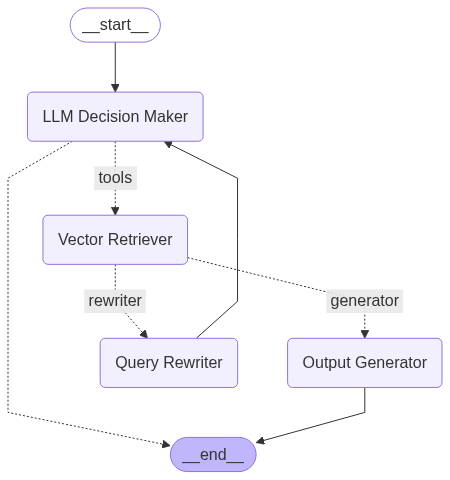

In [38]:
workflow = StateGraph(AgentState)

workflow.add_node("LLM Decision Maker",LLM_Decision_Maker)
workflow.add_node("Vector Retriever",retriever_node)
workflow.add_node("Output Generator",generate)
workflow.add_node("Query Rewriter",rewrite)


workflow.add_edge(START,"LLM Decision Maker")

workflow.add_conditional_edges(
    "LLM Decision Maker",
    tools_condition,
    {
        "tools":"Vector Retriever",
        END:END
    }
)

workflow.add_conditional_edges(
    "Vector Retriever",
    grade_documents,
    {
        "generator":"Output Generator",
        "rewriter":"Query Rewriter"
    }
)

workflow.add_edge("Output Generator", END)
workflow.add_edge("Query Rewriter","LLM Decision Maker")

app = workflow.compile()
app

In [39]:
events = app.stream(
    {
        "messages":["What is Agentic AI? And how Agentic AI can reshape the future software engineering?"]
    },
    stream_mode="values"
)

for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

What is Agentic AI? And how Agentic AI can reshape the future software engineering?
----CALL LLM_DECISION_MAKE----
================================== Ai Message ==================================

Agentic AI refers to artificial intelligence systems that possess a degree of autonomy and can make decisions or take actions based on their programming and learned experiences. These systems can operate independently to achieve specific goals, often mimicking human-like reasoning and decision-making processes. 

In the context of software engineering, Agentic AI can reshape the future in several ways:

1. **Automation of Routine Tasks**: Agentic AI can automate repetitive and mundane tasks in software development, such as code generation, testing, and debugging, allowing engineers to focus on more complex and creative aspects of their work.

2. **Enhanced Decision-Making**: By analyzing vast amounts of data, Ag

In [40]:
events = app.stream(
    {
        "messages":[
            """
            what is Chain of Hindsight?
            """
        ]
    },
    stream_mode="values"
)

for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================


            what is Chain of Hindsight?
            
----CALL LLM_DECISION_MAKE----
================================== Ai Message ==================================
Tool Calls:
  retriever_blog_post (call_QxSzOZHANo3X7Ij7uOdmKjJR)
 Call ID: call_QxSzOZHANo3X7Ij7uOdmKjJR
  Args:
    query: Chain of Hindsight
----CALLING GRADE FOR CHECKING RELEVANCY----
----DECISION: DOCS ARE RELEVANT----
================================= Tool Message =================================
Name: retriever_blog_post

Chain of Hindsight (CoH; Liu et al. 2023) encourages the model to improve on its own outputs by explicitly presenting it with a sequence of past outputs, each annotated with feedback. Human feedback data is a collection of $D_h = \{(x, y_i , r_i , z_i)\}_{i=1}^n$, where $x$ is the prompt, each $y_i$ is a model completion,

Chain of Hindsight (CoH; Liu et al. 2023) encourages the model to improve on its own outputs b

In [41]:
events = app.stream(
    {
        "messages":[
            """
            what is Self-Reflection, in the context of generative ai? and how Self-Reflection is different from ReAct?
            """
        ]
    },
    stream_mode="values"
)

for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================


            what is Self-Reflection, in the context of generative ai? and how Self-Reflection is different from ReAct?
            
----CALL LLM_DECISION_MAKE----
================================== Ai Message ==================================
Tool Calls:
  retriever_blog_post (call_oUryWrBZ40B3IMLxD1DnsddU)
 Call ID: call_oUryWrBZ40B3IMLxD1DnsddU
  Args:
    query: Self-Reflection in generative AI
  retriever_blog_post (call_t9DMUFwCr9DJ2F5GbzVj8ZrV)
 Call ID: call_t9DMUFwCr9DJ2F5GbzVj8ZrV
  Args:
    query: ReAct in generative AI
----CALLING GRADE FOR CHECKING RELEVANCY----
----DECISION: DOCS ARE NOT RELEVANT----
================================= Tool Message =================================
Name: retriever_blog_post

ReAct (Yao et al. 2023) integrates reasoning and acting within LLM by extending the action space to be a combination of task-specific discrete actions and the language space. The former 